In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import math

/Users/zhangben/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def dataset_minmax(train, test):
    train = train[:,np.any(~np.isnan(train),axis=0)]
    test = test[:,np.any(~np.isnan(test),axis=0)]
    train_normalized = (train - train.min(axis=0)) / (train.max(axis=0) - train.min(axis=0))
    test_normalized = (test - test.min(axis=0)) / (test.max(axis=0) - test.min(axis=0))
    return train_normalized, test_normalized

In [3]:
def compute_square_loss(X, y, theta):
    SL = np.dot((np.dot(X,theta[:, np.newaxis])-y[:, np.newaxis]).T, 
                np.dot(X,theta[:, np.newaxis])-y[:, np.newaxis]) / X.shape[0]
    
    return SL[0]

In [4]:
########################################
### compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    SL_gradient = (2 * np.dot(X.T,np.dot(X,theta[:, np.newaxis])-y[:, np.newaxis]) / X.shape[0]).T[0]
    return SL_gradient

In [5]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
 
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    e = np.identity(num_features, dtype = int)
    for i in range(num_features):
        theta_add = theta + epsilon * e[i]
        theta_minus = theta - epsilon * e[i]
        approx_grad[i] = (np.dot((np.dot(X,theta_add[:, np.newaxis])-y[:, np.newaxis]).T,
                         np.dot(X,theta_add[:, np.newaxis])-y[:, np.newaxis]) - 
                         np.dot((np.dot(X,theta_minus[:, np.newaxis])-y[:, np.newaxis]).T,
                         np.dot(X,theta_minus[:, np.newaxis])-y[:, np.newaxis]))/ X.shape[0]*2*epsilon
    dist = np.sqrt(np.sum(np.square(true_gradient - approx_grad)))
    return dist <= tolerance
    
    
    #TODO




In [6]:
#################################################
### Generic Gradient Checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    #TODO

In [91]:
df = pd.read_csv('data.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100,random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = dataset_minmax(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term
X_train.shape, X_test, y_train.shape, y_test

Split into Train and Test
Scaling all to [0, 1]


((100, 49), array([[ 1.        ,  1.        ,  1.        , ...,  0.20824604,
          0.20824604,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.02382113,
          0.02382113,  1.        ],
        [ 1.        ,  0.        ,  0.        , ...,  0.05327638,
          0.05327638,  1.        ],
        ..., 
        [ 1.        ,  0.        ,  0.        , ...,  0.06453959,
          0.06453959,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  0.710993  ,
          0.710993  ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  0.91477366,
          0.91477366,  1.        ]]), (100,), array([-1.07263709, -1.91105204, -1.07036941,  2.46885009,  2.23386039,
        -2.33420095, -1.45941462,  1.64201394,  1.27360956,  1.10870068,
        -2.31118974, -1.88082819, -2.50372482,  4.62920495,  6.3233524 ,
        -1.11729565, -0.69631684, -2.98080986,  0.01242233,  3.50612836,
        -4.83147353,  1.63837478, -1.37630615, -0.40093671,  1

In [8]:
#### Batch Gradient Descent
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.zeros(num_features) #initialize theta
    
    loss_hist[0] = compute_square_loss(X, y, theta)

    for i in range(num_iter):
        theta = theta - alpha*compute_square_loss_gradient(X, y, theta)
        loss_hist[i+1] = compute_square_loss(X, y, theta_hist[i])
        theta_hist[i+1,:] = theta
    return theta_hist, loss_hist
    #TODO



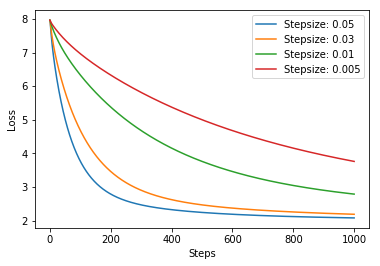

In [52]:
list_alpha=[0.05, 0.03, 0.01, 0.005]
for alpha in list_alpha:
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha, num_iter=1000, check_gradient=False)
    plt.plot(loss_hist,label="Stepsize: "+ str(alpha))

plt.legend()   
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()


In [10]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    grad_theta = 2 *(np.dot(X.T, np.dot(X, theta) - y) + lambda_reg*theta)/ (X.shape[0])
    return grad_theta
    #TODO

In [155]:
def compute_regularized_square_loss(X, y, theta, lambda_reg):
    loss = np.dot(X, theta) - y
    return (np.sum(loss ** 2) +lambda_reg*np.sum(np.dot(theta,theta)))/ (X.shape[0])

In [156]:
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    (num_instances, num_features) = X.shape
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    
    loss_hist[0] = compute_regularized_square_loss(X, y, theta.T, lambda_reg)
    #TODO
    for i in range(num_iter):
        grad = compute_regularized_square_loss_gradient(X, y, theta.T, lambda_reg)
        theta = theta - alpha * grad.T
        loss_hist[i+1] = compute_regularized_square_loss(X, y, theta.T, lambda_reg)
        theta_hist[i+1,:] = theta
    return theta_hist, loss_hist
    
    #TODO

[ 2.32256968] [ 2.59758516]
[ 2.32257103] [ 2.59758334]
[ 2.32270604] [ 2.59740182]
[ 2.33662132] [ 2.5799834]
[ 2.49281979] [ 2.47776163]
[ 4.25005941] [ 2.96216613]
[ 7.02033523] [ 4.42574746]


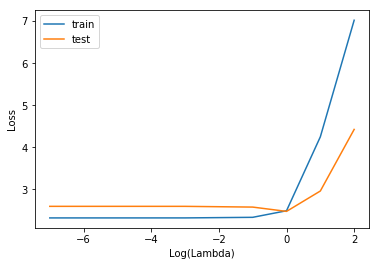

In [157]:
list_lambda=[1e-7,1e-5,1e-3,1e-1,1,10,100]
llist_train = []
losslist_train = []
llist_test = []
losslist_test = []
for l in list_lambda:
    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=l, alpha=0.02, num_iter=1000)
    theta_train=theta_hist[-1]
    train_loss = compute_square_loss(X_train, y_train, theta_train)
    test_loss = compute_square_loss(X_test, y_test, theta_train)
    llist_train.append(math.log10(l))
    losslist_train.append(train_loss)
    llist_test.append(math.log10(l))
    losslist_test.append(test_loss)
    print(train_loss,test_loss)

plt.plot(llist_train,losslist_train,label="train")
plt.plot(llist_test,losslist_test,label="test")
plt.legend()   
plt.xlabel('Log(Lambda)')
plt.ylabel('Loss')
plt.show()

[ 2.4232931] [ 2.50876831]
[ 2.44590168] [ 2.49687399]
[ 2.47390422] [ 2.48466494]
[ 2.50860858] [ 2.47272547]
[ 2.55159619] [ 2.46190499]
[ 2.60474023] [ 2.4533708]
[ 2.67019865] [ 2.44864687]
[ 2.75036591] [ 2.44962248]
[ 2.84776562] [ 2.45851033]
[ 2.96486859] [ 2.47773357]


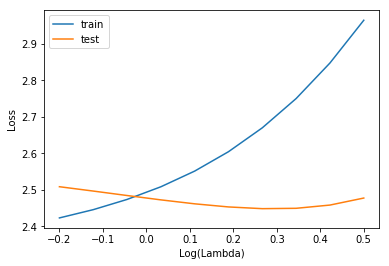

In [158]:
list_lambda=[10**x for x in np.linspace(-0.2,0.5,10)]
llist_train = []
losslist_train = []
llist_test = []
losslist_test = []
for l in list_lambda:
    theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=l, alpha=0.02, num_iter=1000)
    theta_train=theta_hist[-1]
    train_loss = compute_square_loss(X_train, y_train, theta_train)
    test_loss = compute_square_loss(X_test, y_test, theta_train)
    llist_train.append(math.log10(l))
    losslist_train.append(train_loss)
    llist_test.append(math.log10(l))
    losslist_test.append(test_loss)
    print(train_loss,test_loss)

plt.plot(llist_train,losslist_train,label="train")
plt.plot(llist_test,losslist_test,label="test")
plt.legend()   
plt.xlabel('Log(Lambda)')
plt.ylabel('Loss')
plt.show()

No handles with labels found to put in legend.


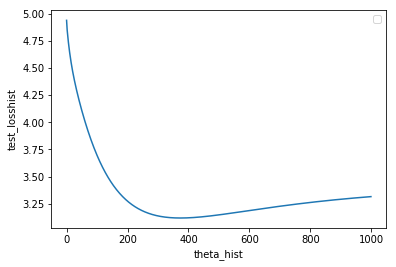

Lowest loss is 3.11793016157 
 Best theta which gives the lowest loss is [ -9.00402125e-01   3.85685744e-01   1.08183750e+00   1.39942161e+00
  -9.01466487e-01  -6.28496325e-01  -5.68473284e-01  -5.68473284e-01
   4.02634667e-01   1.08412967e+00   1.44352293e+00  -1.19457981e-01
  -1.34616559e+00  -2.52978755e+00   1.08157548e+00   1.61254062e+00
   1.17188746e+00   2.71238695e-01  -7.87481984e-02  -7.87481984e-02
  -7.87481984e-02  -6.36017399e-03  -6.36017399e-03  -6.36017399e-03
   2.18325496e-02   2.18325496e-02   2.18325496e-02   3.53277417e-02
   3.53277417e-02   3.53277417e-02   4.29522384e-02   4.29522384e-02
   4.29522384e-02  -9.60892835e-04  -9.60892835e-04  -9.60892835e-04
   1.09965622e-01   1.09965622e-01   1.09965622e-01   8.95927569e-02
   8.95927569e-02   8.95927569e-02   8.02491636e-02   8.02491636e-02
   8.02491636e-02   7.50896218e-02   7.50896218e-02   7.50896218e-02
  -1.13514056e+00]


In [178]:
theta_hist_train, loss_hist_train = regularized_grad_descent(X_train, y_train, lambda_reg=2, alpha=0.02, num_iter=1000)
(num_instances, num_features) = X_test.shape
theta_hist_train=theta_hist_train[1:]
num_iter=1000
test_losshist = np.zeros(num_iter) #Initialize loss_hist 
# loss_hist[0] = compute_regularized_square_loss(X.test, y, theta_hist[0].T, lambda_reg)

for i in range(num_iter):
    test_losshist[i] = compute_regularized_square_loss(X_test, y_test, theta_hist_train[i].T, lambda_reg=2)

x_theta=range(1000)
plt.plot(x_theta, test_losshist)
plt.legend()   
plt.xlabel('theta_hist')
plt.ylabel('test_losshist')
plt.show()
print ("Lowest loss is",np.ndarray.min(test_losshist),'\n',
       "Best theta which gives the lowest loss is", theta_hist[np.argmin(test_losshist)])

(1000, 49)

In [81]:
theta_hist, loss_hist = regularized_grad_descent(X_train, y_train, lambda_reg=2, alpha=0.02, num_iter=1000)
theta_hist.shape

(1001, 49)

In [68]:
lambda_reg=math.pow(10,0.3)
lambda_reg

1.9952623149688795

In [ ]:
Regularization is based on the idea that overfitting on Y is caused by a being "overly specific",
so to speak, which usually manifests itself by large values of theta's elements.

Bias b is an added element, which is less important when compared with multiplied factor theta.
Moreover, in case a large offset is needed for whatever reason, 
regularizing it will prevent finding the correct relationship. So we would like to leave b unregularized.


will offset the relationship between x and y,  and its scale therefore is far less important
to this problem.

In [360]:
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta

    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    l=list(range(num_instances))     
    for i in range(num_iter):
        np.random.shuffle(l)
        for j in l:
            if alpha == '1/t':
                alpha = 1/(i+2000)
            elif alpha=='1/sqrt(t)':
                alpha = 1/np.sqrt(i+5000)
            elif alpha == 'eta/1+t_eta':
                alpha = 0.1/(1+0.1*lambda_reg*(i+5000))
            a=j
            grad_theta = 2*np.dot(X[a].T, np.dot(X[a], theta.T) - y[a]) + 2 * lambda_reg*theta 

            theta = theta - alpha*grad_theta
            loss_hist[i,j]=compute_square_loss(X,y,theta)
            theta_hist[i,j] = theta
    return theta_hist, loss_hist
#         grad = compute_regularized_square_loss_gradient(X, y, theta.T, lambda_reg)
#         theta = theta - alpha * grad.T
#         loss_hist[i+1] = compute_regularized_square_loss(X, y, theta.T, lambda_reg)
#         theta_hist[i+1,:] = theta    
    #TODO

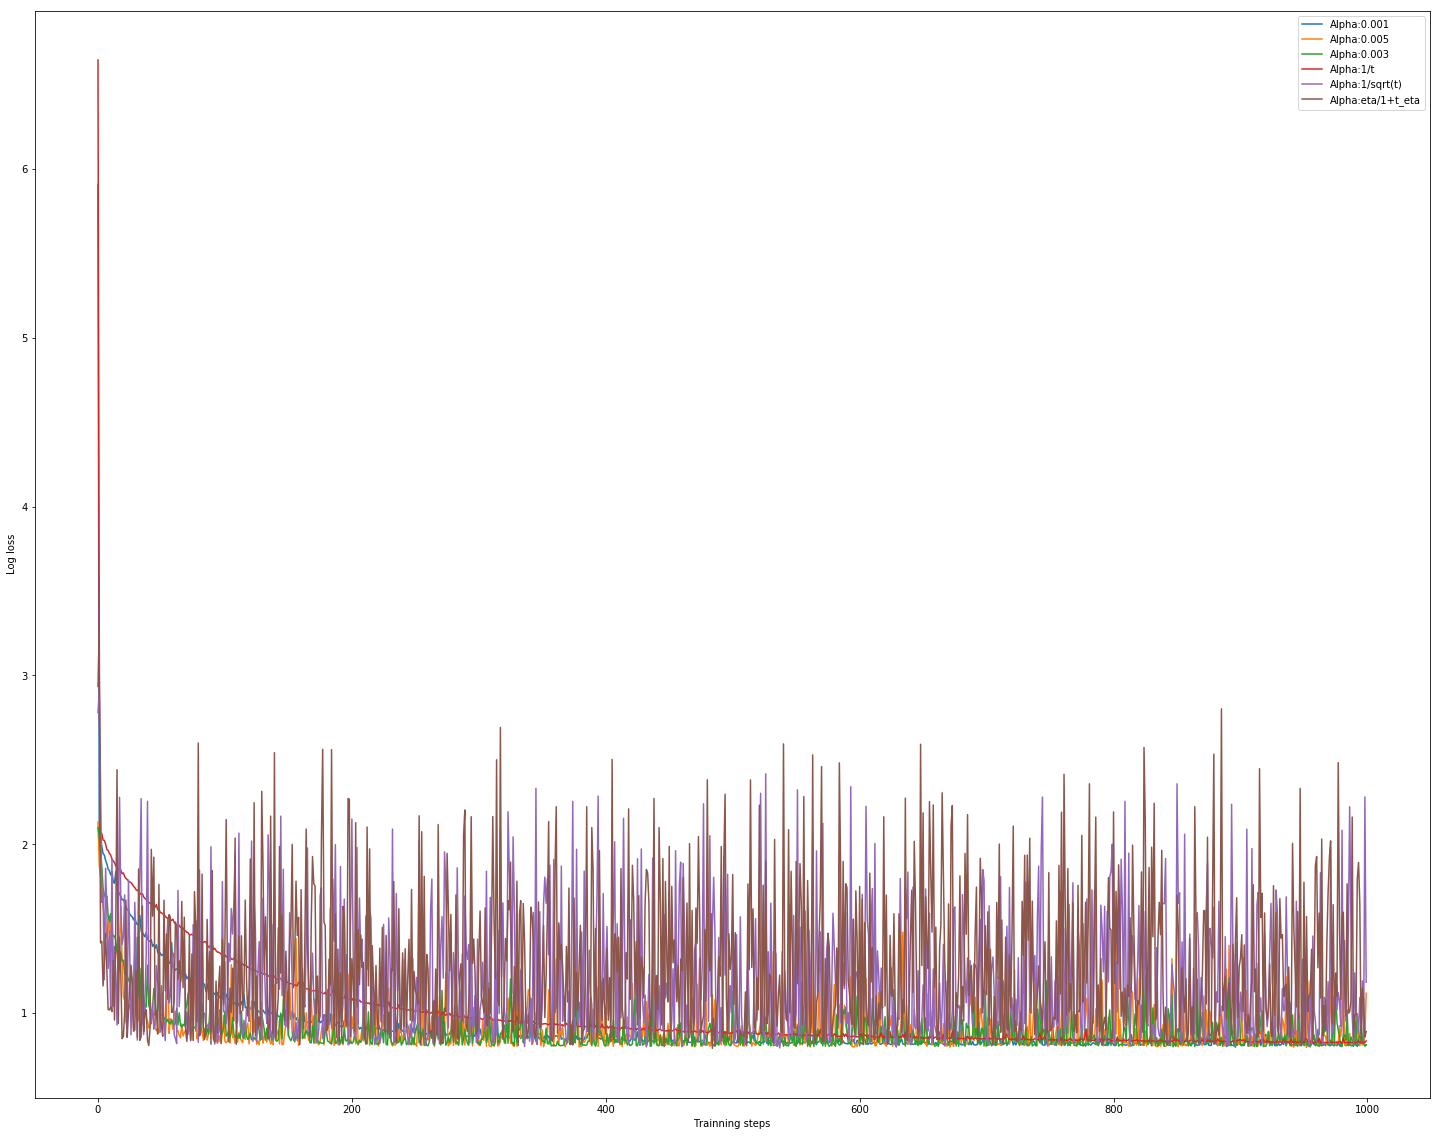

In [361]:
def Finding_SDG(X,y):
    alphas =[0.001, 0.005, 0.003, '1/t', '1/sqrt(t)', 'eta/1+t_eta']
    plt.figure(figsize=(25,20))
    for alpha in alphas:
        thetas, losses = stochastic_grad_descent(X, y, alpha, lambda_reg=1e-2, num_iter=1000)
        plt.plot(np.log(losses[:,-1]), label = "Alpha:" + str(alpha))
    plt.legend()
    plt.xlabel("Trainning steps")
    plt.ylabel("Log loss")   
    plt.show()
Finding_SDG(X_train,y_train)

In [ ]:
X=np.array(np.mat('1 2; 3 4'))
Y=np.array([1, 2])
thetatest=np.array([0.5, 0.8])
Loss=compute_square_loss1(X, Y, thetatest)
Loss